In [1]:
import os, sys, subprocess, fitsio, shutil
from collections import Counter

import numpy as np
from astropy.table import Table
from astropy.io import fits

import desimodel.io
import desimodel.focalplane
import desimodel.footprint
from desitarget.targetmask import desi_mask, obsconditions
import matplotlib.pyplot as plt
%matplotlib inline

**Learning goals**

In this notebook you will learn how to:

* Generate mock files from simulations to feed into fiberassign.
* Run fiberassign using the files generated above.
* Explore the outputs of fiberassign to estimate its efficiency.

This notebook has been tested against `desi_environment` 19.2.

This notebook reuses code by S. Bailey https://github.com/desihub/tutorials/blob/master/FiberAssign.ipynb

In [2]:
workdir = os.getenv('SCRATCH') + '/desi/test/fiberassign_mock'
os.makedirs(workdir, exist_ok=True)
outdir = workdir + '/output'
os.makedirs(outdir, exist_ok=True)
shutil.copy('input.yaml', workdir)
os.chdir(workdir)

In [3]:
# This is the content of the configuration file to be passed to select_mock_targets
!cat input.yaml

# mock target configuration file
targets:
    ELG: {
        target_type: ELG,
        mockfile: '{DESI_ROOT}/mocks/DarkSky/v1.0.1/elg_0_inpt.fits',
        format: gaussianfield,
        density: 2400,
    }
    LRG: {
        target_type: LRG,
        mockfile: '{DESI_ROOT}/mocks/DarkSky/v1.0.1/lrg_0_inpt.fits',
        format: gaussianfield,
        density: 480,
    }
    QSO: {
        target_type: QSO,
        mockfile: '{DESI_ROOT}/mocks/DarkSky/v1.0.1/qso_0_inpt.fits',
        format: gaussianfield,
        zmax_qso: 1.8,
        use_simqso: True,
        density: 120,
    }
    LYA: {
        target_type: QSO,
        mockfile: '{DESI_ROOT}/mocks/lya_forest/develop/london/v4.0/master.fits',
        format: CoLoRe,
        nside_lya: 16,
        zmin_lya: 1.8,
        density: 50,
        use_simqso: True,
        balprob: 0.0,
        add_dla: True,
    }
    MWS_MAIN: {
        target_type: STAR,
        mockfile: '{DESI_ROOT}/mocks/mws/galaxia/alpha/v0.0.6/healpix',
        

Some more files needed to run fiberassign

In [4]:
mtlfile = os.path.join(workdir, 'mtl.fits')
truthfile = os.path.join(workdir, 'truth.fits')
starfile = os.path.join(workdir, 'std.fits')
targetcutfile = os.path.join(workdir, 'targets.fits') 
skycutfile = os.path.join(workdir, 'sky.fits') 
tilefile = os.path.join(workdir, "tiles.fits")

In [5]:
# tile selection
program = "dark"

tiles = desimodel.io.load_tiles()
bright = tiles['PROGRAM']=='BRIGHT'
    
small = ((tiles['RA']>12) & (tiles['RA']<20) & (tiles['DEC']<1) & (tiles['DEC']>-1))

if program=="bright":
    Table(tiles[(bright)&(small)]).write(tilefile, overwrite=True)
else:
    Table(tiles[(~bright) & (small)]).write(tilefile, overwrite=True)

print("Wrote tiles to {}".format(tilefile))

Wrote tiles to /global/cscratch1/sd/forero/desi/test/fiberassign_mock/tiles.fits


In [6]:
!pwd
!ls

/global/cscratch1/sd/forero/desi/test/fiberassign_mock
input.yaml  output  tiles.fits


In [7]:
cmd = "srun -A desi -N 2 -n 16 -c 8"  # -c 8 not 4 for hyperthreading
cmd += " -C haswell -t 01:00:00 --qos interactive "
cmd += " mpi_select_mock_targets --no-spectra --nproc 4 --nside 32 --seed 10"
cmd += " -c ./input.yaml "
cmd += " --output_dir ./ "
cmd += " --tiles ./tiles.fits"
print(cmd)

srun -A desi -N 2 -n 16 -c 8 -C haswell -t 01:00:00 --qos interactive  mpi_select_mock_targets --no-spectra --nproc 4 --nside 32 --seed 10 -c ./input.yaml  --output_dir ./  --tiles ./tiles.fits


In [8]:
# To run target selection comment out these lines. it should take 5 minutes
#print('RUNNING: '+cmd)
#err = subprocess.call(cmd.split())
#print(err)
#assert err == 0


RUNNING: srun -A desi -N 2 -n 16 -c 8 -C haswell -t 01:00:00 --qos interactive  mpi_select_mock_targets --no-spectra --nproc 4 --nside 32 --seed 10 -c ./input.yaml  --output_dir ./  --tiles ./tiles.fits
0


In [9]:
cmd = 'join_mock_targets --overwrite --mockdir ./'
print('RUNNING: '+cmd)
err = subprocess.call(cmd.split())
print(err)
assert err == 0

RUNNING: join_mock_targets --overwrite --mockdir ./
0


Text(0,0.5,'DEC')

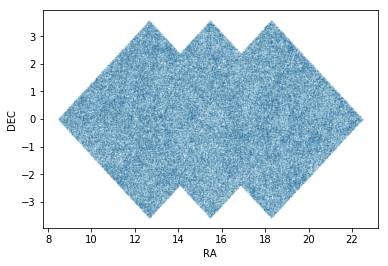

In [10]:
mtldata = Table.read('mtl.fits')
plt.scatter(mtldata['RA'], mtldata['DEC'],s=0.1, alpha=0.1)
plt.xlabel('RA')
plt.ylabel('DEC')

In [11]:
# Run fiberassign
cmd = 'fiberassign --overwrite --mtl mtl.fits --stdstar standards-dark.fits --sky sky.fits'
cmd += ' --footprint ./tiles.fits'
cmd += ' --outdir ./output/'
cmd = cmd.format(outdir=outdir)

In [12]:
print('RUNNING: '+cmd)
err = subprocess.call(cmd.split())
print(err)
assert err == 0

RUNNING: fiberassign --overwrite --mtl mtl.fits --stdstar standards-dark.fits --sky sky.fits --footprint ./tiles.fits --outdir ./output/
0


In [15]:
!ls output

fiberassign_00543.fits	fiberassign_17829.fits	tile-07349.fits
fiberassign_00544.fits	fiberassign_18873.fits	tile-12065.fits
fiberassign_01587.fits	fiberassign_23589.fits	tile-12067.fits
fiberassign_06305.fits	fiberassign_24633.fits	tile-13111.fits
fiberassign_06306.fits	fiberassign_24635.fits	tile-17827.fits
fiberassign_07349.fits	tile-00543.fits		tile-17829.fits
fiberassign_12065.fits	tile-00544.fits		tile-18873.fits
fiberassign_12067.fits	tile-01587.fits		tile-23589.fits
fiberassign_13111.fits	tile-06305.fits		tile-24633.fits
fiberassign_17827.fits	tile-06306.fits		tile-24635.fits


In [16]:
tiles = Table.read("tiles.fits")
targets = Table.read("mtl.fits")

Text(0,0.5,'DEC [deg]')

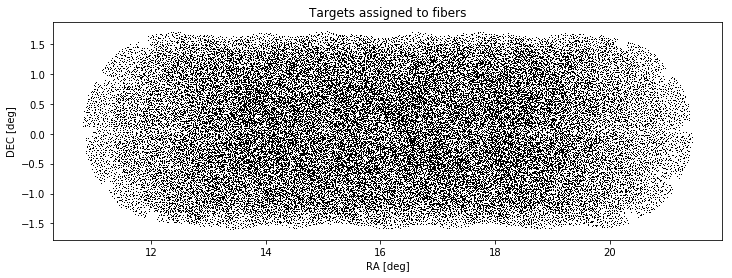

In [18]:
# Gather all outputs
assignments = list()
for tileid in tiles['TILEID']:
    tilefile = '{}/tile-{:05d}.fits'.format(outdir, tileid)
    assignments.append(Table.read(tilefile, hdu=1))
    
assigned_targetids = np.concatenate([tmp['TARGETID'] for tmp in assignments])
isAssigned = np.in1d(targets['TARGETID'], assigned_targetids)

plt.figure(figsize=(12,4))
plt.plot(targets['RA'][isAssigned], targets['DEC'][isAssigned], 'k,')
plt.title('Targets assigned to fibers')
plt.xlabel('RA [deg]')
plt.ylabel('DEC [deg]')

Text(0,0.5,'DEC [deg]')

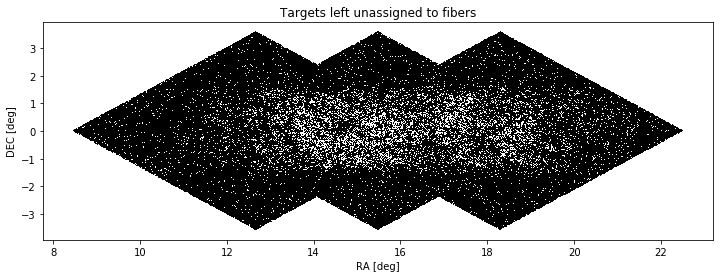

In [19]:
plt.figure(figsize=(12,4))
plt.plot(targets['RA'][~isAssigned], targets['DEC'][~isAssigned], 'k,')
plt.title('Targets left unassigned to fibers')
plt.xlabel('RA [deg]')
plt.ylabel('DEC [deg]')